# Determination of Vitamin C Concentration Using NIR Spectroscopy and Chemometric Modeling

## Experiment Configuration

In [1]:
# Config
FILE_PATH    = "./EC_Coated_VitC_newData.xlsx"
WVN_COL      = "Wavenumber (cm-1)"
TARGET_VAR   = "VC"        # predict Vitamin C amount
N_INTERVALS  = 25         # iPLS intervals across spectrum
PLS_MAX_COMP = 10          # max components to try
INNER_CV     = 5           # inner CV for iPLS selection (KFold)
RANDOM_SEED  = 0


## Load and Read Data

In [2]:
import numpy as np
import pandas as pd
raw_data  = pd.read_excel(FILE_PATH)
raw_data

,Wavenumber (cm-1),Glanbia Absorbance EC VC Only 10.2 mg 1.0,Glanbia Absorbance EC VC Only 10.2 mg 2.0,Glanbia Absorbance EC VC Only 10.2 mg 3.0,Glanbia Absorbance EC VC Only 100.0 mg 1.0,Glanbia Absorbance EC VC Only 100.0 mg 2.0,Glanbia Absorbance EC VC Only 100.0 mg 3.0,Glanbia Absorbance EC VC Only 15.2 mg 1.0,Glanbia Absorbance EC VC Only 15.2 mg 2.0,Glanbia Absorbance EC VC Only 15.2 mg 3.0,...,Glanbia Absorbance EC VC Only 80.0 mg 3.0,Glanbia Absorbance EC VC Only 85.1 mg 1.0,Glanbia Absorbance EC VC Only 85.1 mg 2.0,Glanbia Absorbance EC VC Only 85.1 mg 3.0,Glanbia Absorbance EC VC Only 90.1 mg 1.0,Glanbia Absorbance EC VC Only 90.1 mg 2.0,Glanbia Absorbance EC VC Only 90.1 mg 3.0,Glanbia Absorbance EC VC Only 95.2 mg 1.0,Glanbia Absorbance EC VC Only 95.2 mg 2.0,Glanbia Absorbance EC VC Only 95.2 mg 3.0
0,9982.187783,1.272654,1.278098,1.266941,0.580719,0.579571,0.580573,1.152189,1.150995,1.157008,...,0.634509,0.628142,0.629023,0.627930,0.604951,0.604676,0.604373,0.598957,0.598083,0.599327
1,9966.759363,1.272513,1.277312,1.266504,0.580135,0.579120,0.579552,1.152920,1.151329,1.157426,...,0.634111,0.627259,0.628536,0.627270,0.604124,0.604000,0.603789,0.598175,0.597485,0.598564
2,9951.330943,1.271813,1.275889,1.266628,0.579473,0.578964,0.578794,1.153507,1.151138,1.156251,...,0.633786,0.626681,0.627953,0.626528,0.603324,0.603075,0.603260,0.597580,0.597095,0.597913
3,9935.902523,1.272089,1.275883,1.266830,0.578819,0.578707,0.578278,1.153210,1.151813,1.154442,...,0.633164,0.626378,0.627470,0.625873,0.602543,0.602123,0.602834,0.597075,0.596678,0.597378
4,9920.474103,1.272481,1.277345,1.266798,0.578226,0.578086,0.577794,1.152034,1.152483,1.153300,...,0.632331,0.625989,0.626885,0.625403,0.601825,0.601396,0.602379,0.596588,0.596127,0.596880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,4057.674478,1.790035,1.793331,1.789939,1.433732,1.433560,1.433292,1.766831,1.766956,1.770478,...,1.507438,1.489860,1.489938,1.489105,1.485653,1.485168,1.485383,1.439364,1.438717,1.439467
385,4042.246058,1.811944,1.814827,1.811389,1.473163,1.472890,1.472808,1.793015,1.793330,1.796766,...,1.544538,1.527419,1.527856,1.526693,1.523629,1.522964,1.523259,1.479334,1.479177,1.479577
386,4026.817637,1.818419,1.821375,1.817016,1.485214,1.484923,1.485190,1.800696,1.800964,1.804181,...,1.555991,1.538301,1.539460,1.538467,1.535447,1.534516,1.535139,1.491508,1.491639,1.491913
387,4011.389217,1.808088,1.811362,1.806044,1.466130,1.465996,1.466337,1.788520,1.788102,1.791512,...,1.538520,1.519867,1.521439,1.520983,1.517613,1.516457,1.517472,1.472193,1.472228,1.472696


## Imports Necessary Libraries

In [3]:
import os, re, warnings
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, KFold, cross_val_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)

## Parse headers

In [4]:
assert WVN_COL in raw_data.columns, f"Missing '{WVN_COL}'. Available columns: {raw_data.columns.tolist()[:8]}"

# all spectral columns are "not wavenumber"
spec_cols = [c for c in raw_data.columns if c != WVN_COL]

# parse each spectral column into (pattern, VC, std)
parsed = []
for c in spec_cols:
    s = str(c)
    # example pattern: "sample 5 mg 0.2"
    m = re.match(r"(.+?)\s([\d.]+)\s*mg\s*([\d.]+)$", s)
    if m:
        pattern, vc, std = m.groups()
        pattern = f"{pattern} {vc} mg {std}"
        parsed.append((pattern, float(vc), float(std)))
    else:
        # fallback: take first two numbers
        nums = re.findall(r"([\d.]+)", s)
        if len(nums) >= 2:
            vc, std = float(nums[0]), float(nums[1])
            parsed.append((s, vc, std))
        else:
            raise ValueError(f"Could not parse VC/std from column header: '{s}'")

ys = pd.DataFrame(parsed, columns=["pattern", "VC", "std"])
# keep parsed entries correspond to actual Excel columns
ys = ys[ys["pattern"].isin(spec_cols)].reset_index(drop=True)

ys

,pattern,VC,std
0,Glanbia Absorbance EC VC Only 10.2 mg 1.0,10.2,1.0
1,Glanbia Absorbance EC VC Only 10.2 mg 2.0,10.2,2.0
2,Glanbia Absorbance EC VC Only 10.2 mg 3.0,10.2,3.0
3,Glanbia Absorbance EC VC Only 100.0 mg 1.0,100.0,1.0
4,Glanbia Absorbance EC VC Only 100.0 mg 2.0,100.0,2.0
5,Glanbia Absorbance EC VC Only 100.0 mg 3.0,100.0,3.0
6,Glanbia Absorbance EC VC Only 15.2 mg 1.0,15.2,1.0
7,Glanbia Absorbance EC VC Only 15.2 mg 2.0,15.2,2.0
8,Glanbia Absorbance EC VC Only 15.2 mg 3.0,15.2,3.0
9,Glanbia Absorbance EC VC Only 20.2 mg 1.0,20.2,1.0


## Build matrices
### Build X, y, wavenumber, groups

In [5]:
# raw rows = wavenumbers, columns = spectra -> transpose it to samples x features
X   = raw_data[ys["pattern"].tolist()].T.to_numpy(dtype=float)   # (n_samples, n_wvn)
wvn = raw_data[WVN_COL].to_numpy(dtype=float)                    # (n_wvn,)
Y   = ys[[TARGET_VAR]].to_numpy(dtype=float)                # (n_samples, 1)

# group by VC concentration for LOGO-CV
groups = ys["VC"].to_numpy()
# Create a new column for group based on VC concentrations
ys['group'] = ys['VC'].astype('category').cat.codes + 1  # Convert VC to group codes starting from 1

# Print the dataframe showing pattern, VC, std, and group
print(ys[['pattern', 'VC', 'std', 'group']].to_string())  # Display group

# sanity checks
assert X.shape[0] == Y.shape[0], "Samples mismatch between X and Y."
assert X.shape[1] == wvn.shape[0], "Features in X != length of wavenumber axis."
# Group Count Validation
n_samples, n_feat = X.shape
n_groups = len(np.unique(groups))
assert n_groups >= 2, "Need at least 2 unique groups for GroupKFold."

print(f"Loaded: samples={n_samples}, features={n_feat}, groups={n_groups}")


                                       pattern     VC  std  group
0    Glanbia Absorbance EC VC Only 10.2 mg 1.0   10.2  1.0      2
1    Glanbia Absorbance EC VC Only 10.2 mg 2.0   10.2  2.0      2
2    Glanbia Absorbance EC VC Only 10.2 mg 3.0   10.2  3.0      2
3   Glanbia Absorbance EC VC Only 100.0 mg 1.0  100.0  1.0     20
4   Glanbia Absorbance EC VC Only 100.0 mg 2.0  100.0  2.0     20
5   Glanbia Absorbance EC VC Only 100.0 mg 3.0  100.0  3.0     20
6    Glanbia Absorbance EC VC Only 15.2 mg 1.0   15.2  1.0      3
7    Glanbia Absorbance EC VC Only 15.2 mg 2.0   15.2  2.0      3
8    Glanbia Absorbance EC VC Only 15.2 mg 3.0   15.2  3.0      3
9    Glanbia Absorbance EC VC Only 20.2 mg 1.0   20.2  1.0      4
10   Glanbia Absorbance EC VC Only 20.2 mg 2.0   20.2  2.0      4
11   Glanbia Absorbance EC VC Only 20.2 mg 3.0   20.2  3.0      4
12   Glanbia Absorbance EC VC Only 24.9 mg 1.0   24.9  1.0      5
13   Glanbia Absorbance EC VC Only 24.9 mg 2.0   24.9  2.0      5
14   Glanb

## Preprocessing

In [6]:
# SNV (Standard Normal Variate)
def snv(Xm):
    Xm = np.asarray(Xm, dtype=float)
    mu = Xm.mean(axis=1, keepdims=True)
    sd = Xm.std(axis=1, keepdims=True)
    sd[sd == 0] = 1.0
    return (Xm - mu) / sd

# Savitzky–Golay Smoothing Filter
def apply_savgol(Xm):
    Xm = np.asarray(Xm, dtype=float)
    # choose a window length based on number of vars
    wl = 11 if Xm.shape[1] >= 11 else (Xm.shape[1] if Xm.shape[1] % 2 == 1 else max(1, Xm.shape[1]-1))
    if wl < 3:
        return Xm
    return savgol_filter(Xm, window_length=wl, polyorder=2, axis=1)

SNV     = FunctionTransformer(snv, validate=False)
SAVGOL  = FunctionTransformer(apply_savgol, validate=False)

def pooled_rmse(y_true, y_pred):
    return float(np.sqrt(((y_true - y_pred) ** 2).mean()))


## LOGO-CV PLS on full spectrum

In [7]:
gkf = GroupKFold(n_splits=n_groups)
max_comp = int(max(2, min(PLS_MAX_COMP, X.shape[1]-1, X.shape[0]-1)))

best_rmse_full, best_r2_full, best_n_full = np.inf, -np.inf, None
cv_true_full, cv_pred_full = [], []

rmse_curve = []
for n_comp in range(2, max_comp+1):
    # Building the preprocessing pipeline
    pipe = Pipeline([
        ("snv", SNV),
        ("sg", SAVGOL),
        ("pls", PLSRegression(n_components=n_comp))
    ])
    fold_true, fold_pred = [], []
    for tr, te in gkf.split(X, Y, groups):
        pipe.fit(X[tr], Y[tr])
        yhat = pipe.predict(X[te])
        fold_true.append(Y[te]); fold_pred.append(yhat)
    yt = np.vstack(fold_true); yp = np.vstack(fold_pred)
    rmse = pooled_rmse(yt, yp)
    rmse_curve.append((n_comp, rmse))
    if rmse < best_rmse_full:
        best_rmse_full = rmse
        best_r2_full   = r2_score(yt, yp)
        best_n_full    = n_comp
        cv_true_full, cv_pred_full = yt, yp

print(f"[PLS full] best_n={best_n_full}, RMSE={best_rmse_full:.4f}, R²={best_r2_full:.4f}")

[PLS full] best_n=8, RMSE=7.1350, R²=0.9387


## Forward iPLS helpers

In [8]:
import numpy as np
np.linspace(0, 23, 6, dtype=int)

array([ 0,  4,  9, 13, 18, 23])

In [9]:

def split_intervals(n_vars, n_intervals):
    n_intervals = min(n_intervals, n_vars)
    edges = np.linspace(0, n_vars, n_intervals+1, dtype=int)
    return [(edges[i], edges[i+1]) for i in range(n_intervals)]

def pls_rmsecv_inner(Xm, ym, n_components=5, inner_cv=INNER_CV, seed=RANDOM_SEED):
    # inner CV is plain KFold (not grouped) just for feature selection
    inner_cv = min(inner_cv, max(2, Xm.shape[0]))
    kf = KFold(n_splits=inner_cv, shuffle=True, random_state=seed)
    pls = PLSRegression(n_components=n_components)
    neg_mse = cross_val_score(pls, Xm, ym,
                              scoring=make_scorer(mean_squared_error, greater_is_better=False),
                              cv=kf)
    return float(np.sqrt(-neg_mse.mean()))

def forward_ipls_mask(Xm, ym, n_intervals=50, n_components=5, wvn=None):
    n_samp, n_vars = Xm.shape
    intervals = split_intervals(n_vars, n_intervals)
    remaining = list(range(len(intervals)))
    mask = np.zeros(n_vars, dtype=bool)
    history = []
    last_rmse = np.inf
    idxes = []

    while remaining:
        candidates = []
        for idx in remaining:
            s, e = intervals[idx]
            trial_mask = mask.copy()
            trial_mask[s:e] = True
            X_sel = Xm[:, trial_mask]
            if X_sel.shape[1] < 2 or X_sel.shape[0] <= 2:
                continue
            n_comp = int(min(n_components, X_sel.shape[1], X_sel.shape[0]-1))
            if n_comp < 1:
                continue
            rmse = pls_rmsecv_inner(X_sel, ym, n_components=n_comp)
            candidates.append((rmse, idx, s, e))
        if not candidates:
            break
        candidates.sort(key=lambda t: t[0])
        rmse, idx, s, e = candidates[0]
        # stop if no improvement
        if rmse >= last_rmse - 1e-8:
            break
        # accept interval
        mask[s:e] = True
        remaining.remove(idx)
        history.append(rmse)
        idxes.append(idx)
        last_rmse = rmse

    # Get the selected wavenumbers based on the mask
    selected_wavenumbers = wvn[mask] if wvn is not None else None

    if selected_wavenumbers is not None:
        print(f"Selected wavenumbers: {selected_wavenumbers}")
    else:
        print("No intervals selected or no improvement found.")

    return mask, history, selected_wavenumbers, (s,e), intervals, idxes  # Return selected wavenumbers


In [10]:
# choose a modest components cap for selection
n_comp_sel = int(min(5, max_comp))

## Run forward iPLS and evaluate
## preprocess once for selection

In [11]:
max_comp_sel = int(max(2, PLS_MAX_COMP))

best_rmse_ipls, best_r2_ipls, best_n_ipls = np.inf, -np.inf, None
cv_true_ipls, cv_pred_ipls = [], []

for n_comp in range(2, max_comp_sel+1):
    fold_true, fold_pred = [], []
    pipe_tr = Pipeline([
            ("snv", SNV),
            ("sg", SAVGOL),
            #("pls", PLSRegression(n_components=n_comp_use))
        ])
    X_pp = pipe_tr.fit_transform(X)
    for tr, te in gkf.split(X, Y, groups):
        ipls_mask, ipls_hist, selected_wavenumbers, (s,e), intervals, idxes = forward_ipls_mask(
            X_pp[tr],
            Y[tr],
            n_intervals=N_INTERVALS,
            n_components=n_comp_sel,
            wvn=wvn
        )
        if not ipls_mask.any():
            print("[iPLS] No interval improved RMSE; falling back to full spectrum for iPLS model.")
            ipls_mask = np.ones(X.shape[1], dtype=bool)
        
        X_sel = X[tr][:, ipls_mask]
        
        n_comp_use = int(min(n_comp, X_sel.shape[1], X_sel.shape[0]))
        
        pipe = Pipeline([
            ("snv", SNV),
            ("sg", SAVGOL),
            ("pls", PLSRegression(n_components=n_comp_use))
        ])
        
        pipe.fit(X_sel, Y[tr])
        yhat = pipe.predict(X[te][:, ipls_mask])
        fold_true.append(Y[te]); fold_pred.append(yhat)
    
    yt = np.vstack(fold_true); yp = np.vstack(fold_pred)
    rmse = pooled_rmse(yt, yp)
    if rmse < best_rmse_ipls:
        best_rmse_ipls = rmse
        best_r2_ipls   = r2_score(yt, yp)
        best_n_ipls    = n_comp  # Store the original n_comp value
        cv_true_ipls, cv_pred_ipls = yt, yp
        
print(f"[iPLS→PLS] best_n={best_n_ipls}, RMSE={best_rmse_ipls:.4f}, R²={best_r2_ipls:.4f}")

Selected wavenumbers: [7343.92795181 7328.49953175 7313.07111168 7297.64269161 7282.21427155
 7266.78585148 7251.35743141 7235.92901134 7220.50059128 7205.07217121
 7189.64375114 7174.21533108 7158.78691101 7143.35849094 7127.93007088
 6865.64692974 6850.21850967 6834.79008961 6819.36166954 6803.93324947
 6788.50482941 6773.07640934 6757.64798927 6742.21956921 6726.79114914
 6711.36272907 6695.93430901 6680.50588894 6665.07746887 6649.64904881
 6387.36590767 6371.9374876  6356.50906754 6341.08064747 6325.6522274
 6310.22380733 6294.79538727 6279.3669672  6263.93854713 6248.51012707
 6233.081707   6217.65328693 6202.22486687 6186.7964468  6171.36802673
 6155.93960667 6140.5111866  6125.08276653 6109.65434647 6094.2259264
 6078.79750633 6063.36908627 6047.9406662  6032.51224613 6017.08382607
 6001.655406   5986.22698593 5970.79856586 5955.3701458  5939.94172573
 5924.51330566 4474.24181938 4458.81339931 4443.38497925 4427.95655918
 4412.52813911 4397.09971905 4381.67129898 4366.24287891 

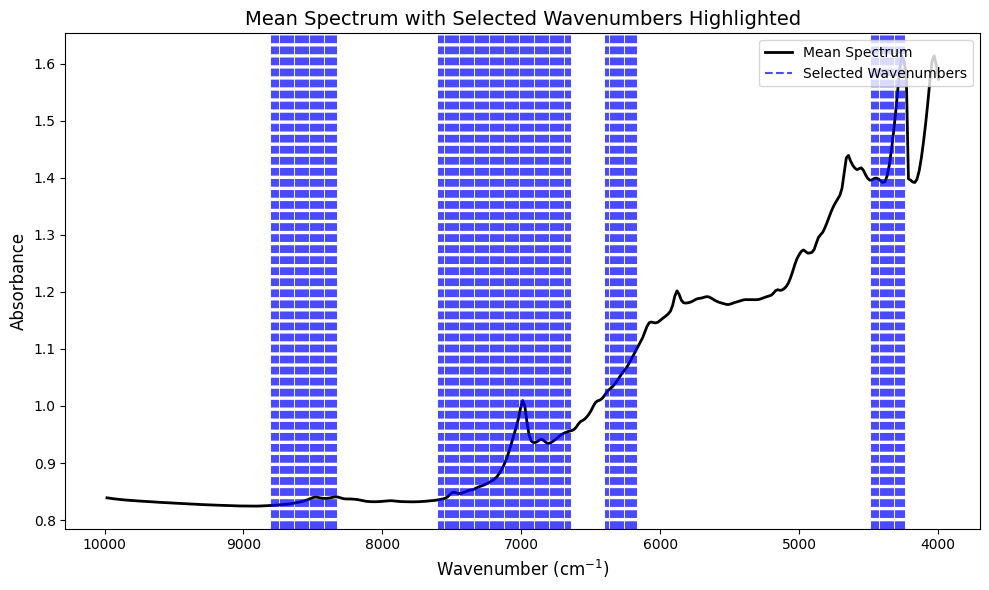

In [12]:
mean_spectrum = X.mean(axis=0)

plt.figure(figsize=(10, 6))
plt.plot(wvn, mean_spectrum, color='black', lw=2, label='Mean Spectrum')

for wn in selected_wavenumbers:
    plt.axvline(x=wn, color='blue', linestyle='--', alpha=0.7)

plt.xlabel("Wavenumber (cm$^{-1}$)", fontsize=12)
plt.ylabel("Absorbance", fontsize=12)
plt.title("Mean Spectrum with Selected Wavenumbers Highlighted", fontsize=14)

plt.legend(["Mean Spectrum", "Selected Wavenumbers"], loc='upper right')
plt.gca().invert_xaxis()

plt.tight_layout()
plt.show()

# Final metrics + plots


================ RESULTS ================
PLS (full spectrum):   RMSE=7.1350, R²=0.9387, best_n=8
iPLS→PLS (selected):   RMSE=7.6159, R²=0.9302, best_n=5
Chosen for plot: iPLS→PLS (components=5)



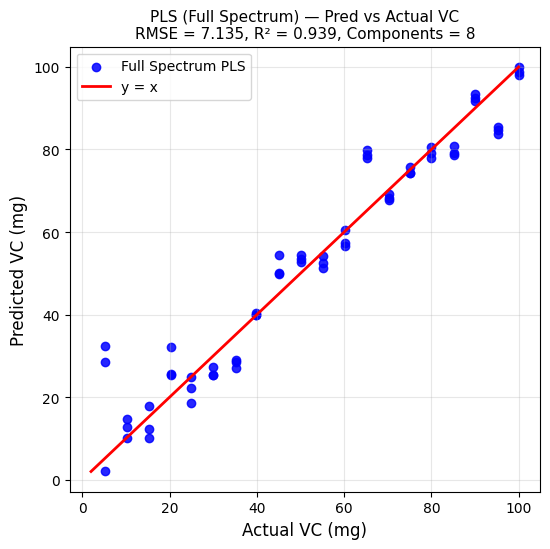

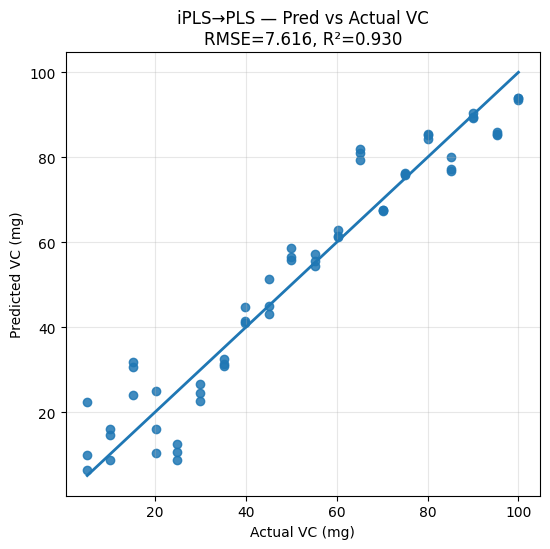

In [13]:
#use_ipls = best_rmse_ipls < best_rmse_full
use_ipls = True
label = "iPLS→PLS" if use_ipls else "PLS (full)"

yt = cv_true_ipls.ravel() if use_ipls else cv_true_full.ravel()
yp = cv_pred_ipls.ravel() if use_ipls else cv_pred_full.ravel()

rmse = best_rmse_ipls if use_ipls else best_rmse_full
r2   = best_r2_ipls   if use_ipls else best_r2_full
best_n = best_n_ipls if use_ipls else best_n_full

print("\n================ RESULTS ================")
print(f"PLS (full spectrum):   RMSE={best_rmse_full:.4f}, R²={best_r2_full:.4f}, best_n={best_n_full}")
print(f"iPLS→PLS (selected):   RMSE={best_rmse_ipls:.4f}, R²={best_r2_ipls:.4f}, best_n={best_n_ipls}")
print(f"Chosen for plot: {label} (components={best_n})")
print("========================================\n")

# 1) full-spectrum plot
yt_full = cv_true_full.ravel()
yp_full = cv_pred_full.ravel()

plt.figure(figsize=(5.6, 5.6))
plt.scatter(yt_full, yp_full, s=36, alpha=0.85, color='blue', label='Full Spectrum PLS')
lo, hi = min(yt_full.min(), yp_full.min()), max(yt_full.max(), yp_full.max())
plt.plot([lo, hi], [lo, hi], color='red', linewidth=2, label='y = x')

plt.xlabel("Actual VC (mg)", fontsize=12)
plt.ylabel("Predicted VC (mg)", fontsize=12)
plt.title(
    f"PLS (Full Spectrum) — Pred vs Actual VC\n"
    f"RMSE = {best_rmse_full:.3f}, R² = {best_r2_full:.3f}, Components = {best_n_full}",
    fontsize=11
)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 2) chosen model plot
plt.figure(figsize=(5.6, 5.6))
plt.scatter(yt, yp, s=36, alpha=0.85)
lo, hi = min(yt.min(), yp.min()), max(yt.max(), yp.max())
plt.plot([lo, hi], [lo, hi], linewidth=2)
plt.xlabel("Actual VC (mg)")
plt.ylabel("Predicted VC (mg)")
plt.title(f"{label} — Pred vs Actual VC\nRMSE={rmse:.3f}, R²={r2:.3f}")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
